In [1]:
import os
import re
import pandas as pd
from pandasql import sqldf

pysqldf = lambda q: sqldf(q, globals())

In [2]:
ETF_data_file = 'results/SSO_simulation.xlsx'
date_column = 'Date'
price_column = 'simulated_SSO'

hold_duration_years = 30
hold_duration_days = 252*hold_duration_years

start_date = '0000-01-01'
end_date = '2023-01-01'

eft = 'sso'

output_file = f'results/{eft}_all_in_return_{hold_duration_years}y.xlsx'

In [3]:
from date_processing import *

In [4]:
if '.csv' in ETF_data_file.lower():
    data = pd.read_csv(
        ETF_data_file,
        )
else:
    data = pd.read_excel(
        ETF_data_file,
        )

data[date_column] = data[date_column].apply(date_normalize)
data[price_column] = data[price_column].apply(str_to_float)

data = pysqldf(u"""
    select 
    {} as date,
    {} as price
    from data
    """.format(
    date_column, 
    price_column
   ))

data = pysqldf(u"""
    select *
    from data
    where date >= '{}' and date <= '{}'
    order by date asc
    """.format(
    start_date, 
    end_date))


data['id'] = data.index

In [5]:
data.head(3)

,date,price,id
0,1928-01-03,0.030510,0
1,1928-01-04,0.030372,1
2,1928-01-05,0.029790,2


# the return

In [6]:
holding = pysqldf(u"""
    select 
    data.date,
    data.price,
    pre_data.date as pre_date,
    pre_data.price as pre_price,
    data.price/pre_data.price as price_ratio
    from data
    join data as pre_data on pre_data.id+{} = data.id
    """.format(hold_duration_days))

In [7]:
holding = pysqldf(u"""
    select *,
    price_ratio -1 as return
    from holding
    """)

In [8]:
holding.head(3)

,date,price,pre_date,pre_price,price_ratio,return
0,1958-03-26,0.030392,1928-01-03,0.030510,0.996135,-0.003865
1,1958-03-27,0.030205,1928-01-04,0.030372,0.994492,-0.005508
2,1958-03-28,0.030248,1928-01-05,0.029790,1.015390,0.015390


<AxesSubplot:xlabel='date'>

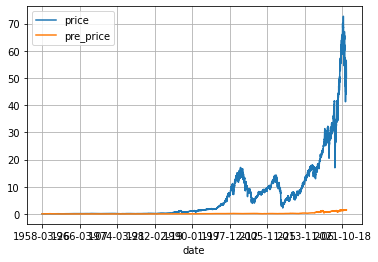

In [9]:
holding.plot(x ='date', y=[
    'price', 
    'pre_price', 
    ], grid = True)

<AxesSubplot:xlabel='date'>

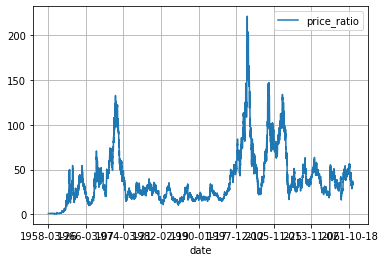

In [10]:
holding.plot(x ='date', y=[
    'price_ratio', 
    ], grid = True)

In [11]:
holding.head()

,date,price,pre_date,pre_price,price_ratio,return
0,1958-03-26,0.030392,1928-01-03,0.030510,0.996135,-0.003865
1,1958-03-27,0.030205,1928-01-04,0.030372,0.994492,-0.005508
2,1958-03-28,0.030248,1928-01-05,0.029790,1.015390,0.015390
3,1958-03-31,0.030105,1928-01-06,0.030163,0.998066,-0.001934
4,1958-04-01,0.029862,1928-01-09,0.029616,1.008276,0.008276


In [12]:
holding.to_excel(
    output_file,
    index = False,
    )

<AxesSubplot:>

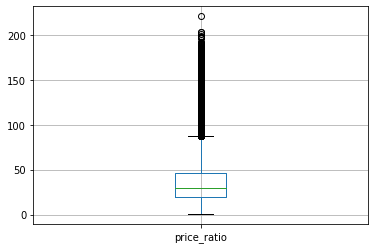

In [13]:
holding.boxplot(column=['price_ratio']) 

In [14]:
price_ratio = holding['price_ratio'].median()

print('Ratio:\t%0.4f'%(price_ratio))

Ratio:	29.7392


END